In [1]:
# CONFIGURATION
queries_file = 'query-files.json'
results_file = 'results/summary-benchmark-2024-09-10T18-14-41.json'

In [2]:
# Define some internal functions

import json

# Function to read a query from a file
def get_query_from_file(file_path):
  # Read the file
  with open(file_path, 'r') as file:
    content = file.read()

  # Trim each part and remove empty parts
  if content.strip():
    content = content.strip()

  content = "# %s\n\n%s" % (file_path, content)

  return content

# Function to load JSON data from a file
def load_json(file_path):
  with open(file_path, 'r') as file:
    data = json.load(file)
  return data

# Function to get metrics values given a key
def get_metrics_values(data, key):
  metrics_key = f"query_{key}_duration"
  if metrics_key in data['metrics']:
    values = data['metrics'][metrics_key]['values']
    return values
  else:
    return None

# Function to search for passes and fails in groups based on the name
def find_passes_fails(data, key):
  groups = data['root_group']['groups']
  query_name = f"Query#{key}"
  for group in groups:
    if group['name'] == query_name:
      for check in group.get('checks', []):
        return { "passes" : check['passes'], "fails" : check['fails'] }
  return None

# Function to get queries from the json index file
def get_queries_from_file(file_path):
  data = load_json(file_path)
  queries = []
  for path_name in data:
    query = get_query_from_file(path_name)
    queries.append(query)
  return queries

In [3]:
# Variables that contains the data we need
queries = get_queries_from_file(queries_file)
results = load_json(results_file)

In [4]:
# Iterate over each query

import html

index = 0
data = []
for query in queries:
  metrics = get_metrics_values(results, index)
  groups = find_passes_fails(results, index)
  index += 1
  avg = None
  med = None
  min = None
  max = None
  p90 = None
  p95 = None
  success = None
  failures = None
  if metrics:
    avg = metrics["avg"]
    med = metrics["med"]
    min = metrics["min"]
    max = metrics["max"]
    p90 = metrics["p(90)"]
    p95 = metrics["p(95)"]
  if groups:
    success = groups["passes"]
    failures = groups["fails"]

  if avg or med or min or max or p90 or p95 or success or failures:
    data.append([html.escape(query).replace('\n', '<br>'), avg, med, min, max, p90, p95, success, failures])


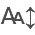

In [5]:
import pandas as pd
from itables import init_notebook_mode, show
from IPython.core.display import HTML

HTML("""
<style>
.custom-table {
  width: auto !important;
}
</style>
""")

init_notebook_mode(all_interactive=True)

df = pd.DataFrame(data, columns=["Query", "Avg (ms)", "Med (ms)", "Min (ms)", "Max (ms)", "p(90) (ms)", "p(95) (ms)", "nb Success", "nb Failures"])
df.to_csv('results/results.csv', index=False)
show(df, maxBytes=0, columnDefs=[{"className": "dt-left", "targets": 0}], classes = "custom-table")

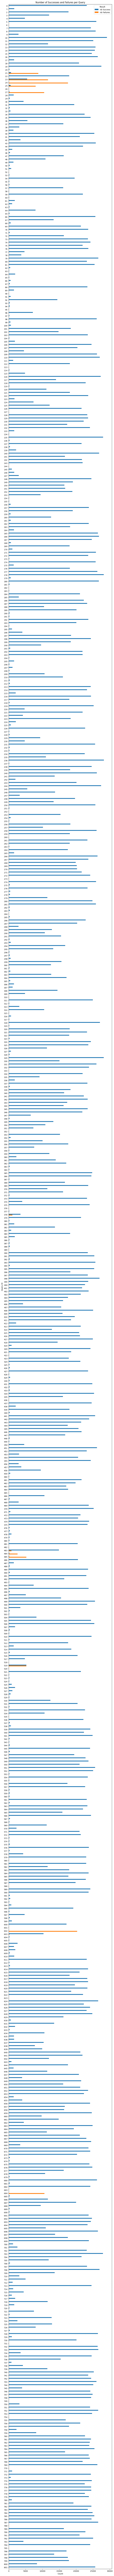

In [6]:
import matplotlib.pyplot as plt

# Use the DataFrame index as the query ID
df['Query ID'] = df.index

# Set 'Query ID' as the index for plotting
df.set_index('Query ID', inplace=True)

# Group by Query ID and sum the success and failure counts
query_results = df[['nb Success', 'nb Failures']]

# Plotting
ax = query_results.plot(kind='barh', stacked=False, figsize=(10, 250))

plt.title('Number of Successes and Failures per Query')
plt.xlabel('Count')
plt.ylabel('Query ID')
plt.xticks(rotation=0)
plt.legend(title='Result')
plt.gca().invert_yaxis()  # Reverse the order on the y-axis
plt.show()

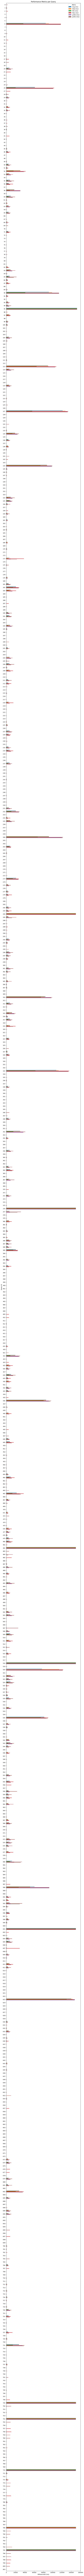

In [7]:
# Select the columns to plot
metrics = df[['Avg (ms)', 'Med (ms)', 'Min (ms)', 'Max (ms)', 'p(90) (ms)', 'p(95) (ms)']]

# Plotting
ax = metrics.plot(kind='barh', stacked=False, figsize=(10, 350))

plt.title('Performance Metrics per Query')
plt.ylabel('Query ID')
plt.xlabel('Milliseconds (ms)')
plt.legend(title='Metric')
plt.gca().invert_yaxis()  # Reverse the order on the y-axis
plt.show()